<a href="https://www.kaggle.com/code/omeraydogddu/a-b-testing-on-cookie-cats-dataset?scriptVersionId=169316549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv


 **Dataset story**
 
This notebook uses data from "Mobile Games A/B Testing - Cookie Cats" dataset. It includes A/B test results of Cookie Cats mobile game to examine what happens when the first gate in the game was moved from level 30 to level 40, so when a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. The data we have is from 90189 players that installed the game while the A/B test was running.

So the dataset already contains two samples, and our work is to prepare the data, formulate a hypothesis, explore the data, and perform statistical tests to check our hypothesis.

> **We have five columns in our dataset:**
* userid: represents the unique identifiers of the users that installed Cookie Cats game while the A/B test was running;
* version: has two unique values corresponding to two starting levels, it is intended for dividing the data into two samples for performing a statistical test;
* sum_gamerounds: represents the quantity of rounds played by a certain user;
* retention_1: shows how many users returned to the game one day after installing it;
* retention_7: shows how many users returned to the game seven days after installing it.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
df.shape

(90189, 5)

In [7]:
df['userid'].nunique()

90189

In [8]:
df["version"].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [9]:
df.groupby('version')['sum_gamerounds'].describe().T

version,gate_30,gate_40
count,44700.000000,45489.000000
mean,52.456264,51.298776
std,256.716423,103.294416
min,0.000000,0.000000
25%,5.000000,5.000000
50%,17.000000,16.000000
75%,50.000000,52.000000
max,49854.000000,2640.000000


We can see that mean and median values are close between the two samples, but variances have a humongous difference.

We should build boxplots to look at sum_gamerounds data visually.

<Axes: xlabel='version', ylabel='sum_gamerounds'>

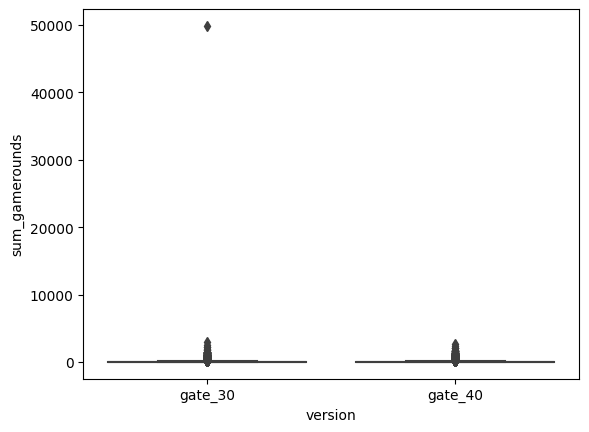

In [10]:
sns.boxplot(x=df["version"], y=df["sum_gamerounds"])

In [11]:
control_group = df[df['version'] == "gate_30"]
test_group = df[df['version'] == "gate_40"]

In [12]:
print("Control Group: %.4f" % (sum(control_group['retention_1']) / len(control_group)))
print("Test Group: %.4f" % (sum(test_group['retention_1']) / len(test_group)))

print("*"* 50)

print("Control Group: %.4f" % (sum(control_group['retention_7']) / len(control_group)))
print("Test Group: %.4f" % (sum(test_group['retention_7']) / len(test_group)))


Control Group: 0.4482
Test Group: 0.4423
**************************************************
Control Group: 0.1902
Test Group: 0.1820


****************************************************************

The H0 hypothesis is the null hypothesis and the group we are going to test is in the H0 hypothesis. H0 tells us "there is no difference between the two group means". H1 is the inability to accept the H0 hypothesis. After the hypotheses are established, the results of the hypotheses are interpreted by looking at the P value. General acceptance is when the p value is less than 0.05. If the p value is less than 0.05, H0 is rejected and the results are interpreted accordingly.

After the hypothesis tests are realized, the assumptions are checked. Within the scope of assumptions, Normality Assumption and Variance Homogeneity are taken into consideration.

**Normality Assumption:** It is the assumption that the two groups are normally distributed separately from each other.

**Homogeneity of Variances:** It is whether the distributions of the two groups are similar to each other.

> **To summarize the stages:** 

> * Hypotheses are Established.
> * H0: M1 = M2
> * H1: M1 != M2
> * Normality Assumption and Variance Homogeneity are examined.
> * Parametric or Non-Parametric methods are used according to the condition of the variances.
> * The P value resulting from the application of parametric or non-parametric methods is examined and the hypotheses are interpreted.

****************************************************************

****Formulating a hypothesis ****

In fact, the number of gamerounds played by a user can be a good growth metric, so we should see if users played more or fewer gamerounds during A/B testing or if the situation has not changed.

 So, the hypotheses are:
* **Null Hypothesis (H0):** there is no statistical difference in terms of played gamerounds between two game verisons;
* **Alternative Hypothesis (H1):** there is a statistical difference in terms of played gamerounds between two game verisons.
We will use the level of significance equal to 0.05.


> * pvalue : 0.05
> * h0 < pvalue h0: not accepted
> * h0 > pvalue : h0: accepted


# A/B testing 
**First of all, we need to check if the two samples are normally distributed.**

**Normal distribution will allow us to use T-test.**

**Shapiro test for that.**

In [13]:
test_stat, p_value = sts.shapiro(control_group["sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, p_value))
# h0: not accepted

Test Stat = 0.0881, p-value = 0.0000


In [14]:
test_stat, p_value = sts.shapiro(test_group["sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, p_value))
#h0: not accepted

Test Stat = 0.4826, p-value = 0.0000


**The p-values are 0s for both samples, so we reject the null hypothesis for both samples, and we clearly see that they are not normally distributed.**

**Since that, we should use non-parametric Mann-Whitney U test.**

In [15]:
test_stat, p_value = sts.mannwhitneyu(control_group["sum_gamerounds"], test_group["sum_gamerounds"])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, p_value))

Test Stat = 1024331250.5000, p-value = 0.0502
